In [ ]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [3]:
# Load data

# Block boundaries
# Source: https://www2.census.gov/geo/tiger/TIGER2021/TABBLOCK20/tl_2021_06_tabblock20.zip
blocks = gpd.read_file(r"C:\Users\chief\Desktop\gwq_test\blocks\blocks2020_screen.shp")

# sample result measurement well "locations"
# modified to have the geometric mean of MCL exceedances at the well location
wells = gpd.read_file(r"C:\Users\chief\Desktop\gwq_test\wells\wellsmodin_test_1.shp")

# Reproject data to NAD 1983 California (Teale) Albers (Meters)
# https://nrm.dfg.ca.gov/FileHandler.ashx?DocumentID=109326&inline
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "
blocks = blocks.to_crs(proj)
wells = wells.to_crs(proj)

In [4]:
# Get X and Y coordinates of wells points
x_wells = wells["geometry"].x
y_wells = wells["geometry"].y

# Create list of XY coordinate pairs
coords_wells = [list(xy) for xy in zip(x_wells, y_wells)]

# Get extent of blocks feature
min_x_blocks, min_y_blocks, max_x_blocks, max_y_blocks = blocks.total_bounds

# Get list of wells "values"
value_wells = list(wells["mag"])

# Create a copy of blocks dataset
blocks_dissolved = blocks.copy()

# Add a field with constant value of 1
blocks_dissolved["constant"] = 1

# Dissolve all blocks to create one polygon
blocks_dissolved = blocks_dissolved.dissolve(by = "constant").reset_index(drop = True)

In [5]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [6]:
# Split data into testing and training sets
coords_wells_train, coords_wells_test, value_wells_train, value_wells_test = train_test_split(coords_wells, value_wells, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
wells_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_wells_train], crs = proj)
wells_train_gdf["Actual_Value"] = value_wells_train
wells_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_wells_test], crs = proj)
wells_test_gdf["Actual_Value"] = value_wells_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_wells, min_y_wells, max_x_wells, max_y_wells = wells_train_gdf.total_bounds

In [7]:

# Set projection to WGS 84 and reproject data
proj_wgs = 4326
blocks_wgs = blocks.to_crs(proj_wgs)
wells_wgs = wells.to_crs(proj_wgs)
wells_train_gdf_wgs = wells_train_gdf.to_crs(proj_wgs)
wells_test_gdf_wgs = wells_test_gdf.to_crs(proj_wgs)

# Get X and Y coordinates of wells points
x_wells_wgs = wells_wgs["geometry"].x
y_wells_wgs = wells_wgs["geometry"].y

# Create list of XY coordinate pairs
coords_wells_train_wgs = [list(xy) for xy in zip(wells_train_gdf_wgs["geometry"].x, wells_train_gdf_wgs["geometry"].y)]
coords_wells_test_wgs = [list(xy) for xy in zip(wells_test_gdf_wgs["geometry"].x, wells_test_gdf_wgs["geometry"].y)]

# Get minimum and maximum coordinate values of wells points
min_x_wells_wgs, min_y_wells_wgs, max_x_wells_wgs, max_y_wells_wgs = wells_train_gdf_wgs.total_bounds


Text(0.5, 1.0, 'CA Blocks - Well Locations')

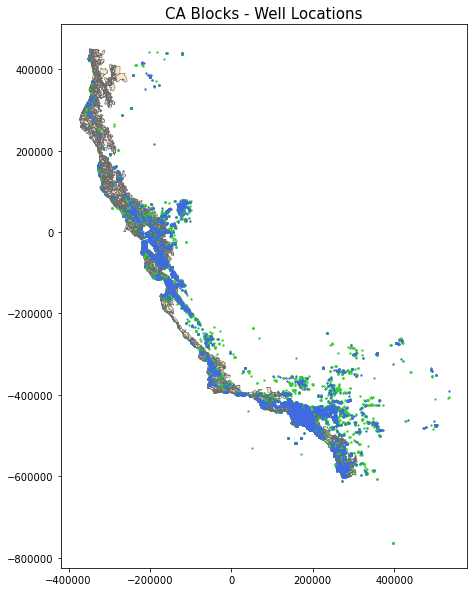

In [8]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
blocks.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
wells_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
wells_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('CA Blocks - Well Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [9]:
# Create a 100 by 100 cell mesh grid
# Horizontal and vertical cell counts should be the same
XX_sk_krig, YY_sk_krig = np.mgrid[min_x_wells_wgs:max_x_wells_wgs:100j, min_y_wells_wgs:max_y_wells_wgs:100j]

# Create 2-D array of the coordinates (paired) of each cell in the mesh grid
positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T

# Generate Gaussian Process model (can change parameters as desired)
gp = GaussianProcessRegressor(n_restarts_optimizer = 10)

# Fit kernel density estimator to coordinates and values
gp.fit(coords_wells_train_wgs, value_wells_train)

# Evaluate the model on coordinate pairs
Z_sk_krig = gp.predict(positions_sk_krig)

# Reshape the data to fit mesh grid
Z_sk_krig = Z_sk_krig.reshape(XX_sk_krig.shape)

In [10]:

# Generate in-sample R^2
in_r_squared_sk_krig = gp.score(coords_wells_train_wgs, value_wells_train)
print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))

# Generate out-of-sample R^2
out_r_squared_sk_krig = gp.score(coords_wells_test_wgs, value_wells_test)
print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))

# Predict values for testing dataset
coords_wells_test_predict_sk_krig = gp.predict(coords_wells_test_wgs)

# Create dictionary holding the actual and predicted values
predict_dict_sk_krig = {"Coordinate_Pair": coords_wells_test_wgs, "VALUE_Actual": value_wells_test, "VALUE_Predict": coords_wells_test_predict_sk_krig}

# Create dataframe from dictionary
predict_df_sk_krig = pd.DataFrame(predict_dict_sk_krig)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method")
display(predict_df_sk_krig.head(2))

Scikit-Learn Kriging in-sample r-squared: 0.0
Scikit-Learn Kriging out-of-sample r-squared: -0.41

Attribute Table: Testing Set Interpolated Values - Scikit-Learn Kriging Method


,Coordinate_Pair,VALUE_Actual,VALUE_Predict
0,"[-117.9883736696406, 33.69371435166385]",13.007690,134.250000
1,"[-124.08736202567452, 40.86975626904678]",11.917771,-9.390625
